# Train a basic classification model

Train a basic Deep Learning model to identify whether a butterfly is Gatekeeper or Meadow Brown. This is going to be a standard classifier, not using our bounding boxes at all. Let's see how well we can do straight off before we try to improve on this in future notebooks by zooming in on our bounding box predictions.

Use [fast.ai](https://www.fast.ai/) v1 library. You'll ideally need a GPU (use a cloud provider e.g. Google as described [here](https://course.fast.ai/start_gcp.html)) and install fast.ai if required.

In [1]:
# Fast.ai imports/setup and model params
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
torch.backends.cudnn.benchmark = True
fastprogress.MAX_COLS = 80

n_gpus = num_distrib() or 1
workers = min(8, num_cpus()//n_gpus)

size = 256 # Image size
bs = 32

lr = 1e-5 # Param("Learning rate", float)=1e-3,
alpha = 0.9 # Param("Alpha", float)=0.9,
mom = 0.9 # Param("Momentum", float)=0.9,
eps = 1e-7 # Param("epsilon", float)=1e-7,
epochs = 25 # Param("Number of epochs", int)=5,
gpu = None # Param("GPU to run on", str)=None,
gpu = setup_distrib(gpu)

np.random.seed(13)

Load our CSV as a Pandas DataFrame from butterflies_bboxes.csv. We aren't using the bounding box data in this notebook but we will exclude those images we've flagged as 'exclude' using the Innotater in the previous notebook '2 - Butterfly Innotater.ipynb'.

In [2]:
BUTTERFLIES_BBOXES_FILEPATH = Path('./butterflies_bboxes.csv')

IMAGE_FOLDER = Path('./butterfly_medium_images')

# Read CSV as Pandas DataFrame
df = pd.read_csv(BUTTERFLIES_BBOXES_FILEPATH)

# Only keep rows with exclude set to 0, remove any marked as 1
df = df[df['exclude'] == 0]

# Reset int index to be continuous - exclude removals will have left gaps
df = df.reset_index(drop=True)

We need to separate out train and validation datasets. Let's take 80% of each class as training data, the remaining 20% reserved for the validation set. This could be done using `split_by_rand_pct()` in the next step, but we might run into a data leakage problem. Flickr photos from the same album are liable to be quite similar. So if two very similar photos end up appearing one in the train set and one in validation we may find the model picks up on unintended artifacts of the photo, e.g. a building in the background. 

Splitting strictly in the order the images appear in the CSV file should mean that individual albums are contained entirely in train or entirely in validation (apart from any album that finds itself exactly on the split point).

In [4]:
# Take first 80% of each class as training data. 
# Prepare a list of indexes that have been selected for the validation set.

train_class_count = int(0.8*df['class'].value_counts().values.min())

valid_idxs = []
for c in df['class'].unique(): # Step through 'gatekeeper_butterfly' and 'meadow_brown_butterfly'
    valid_idxs.extend(df[df['class'] == c].index.values[train_class_count:])
    
print(len(valid_idxs), len(df))

111 541


In [5]:
# Standard fast.ai method for getting a data object composed of images based on `filename` column 
# in DataFrame, with classification labels from the `class` column.
data = (ImageList.from_df(df, path=IMAGE_FOLDER, folder='', cols='filename') # use filename col in DataFrame
        .split_by_idx(valid_idxs) # Split into train/validation set based on validation ids given
        .label_from_df('class') # Create labels for all images based on the 'class' col in DataFrame
        .transform(get_transforms(), size=size) # Apply sensible default data augmentation to training set
        .databunch(bs=bs, num_workers=workers) # Draw into a DataBunch object with an easy API to pull batches
        .presize(size, scale=(0.75,1)) # Ensure sizes are as required
        .normalize(imagenet_stats)) # Normalize image pixel values based on known ImageNet mean/std-dev

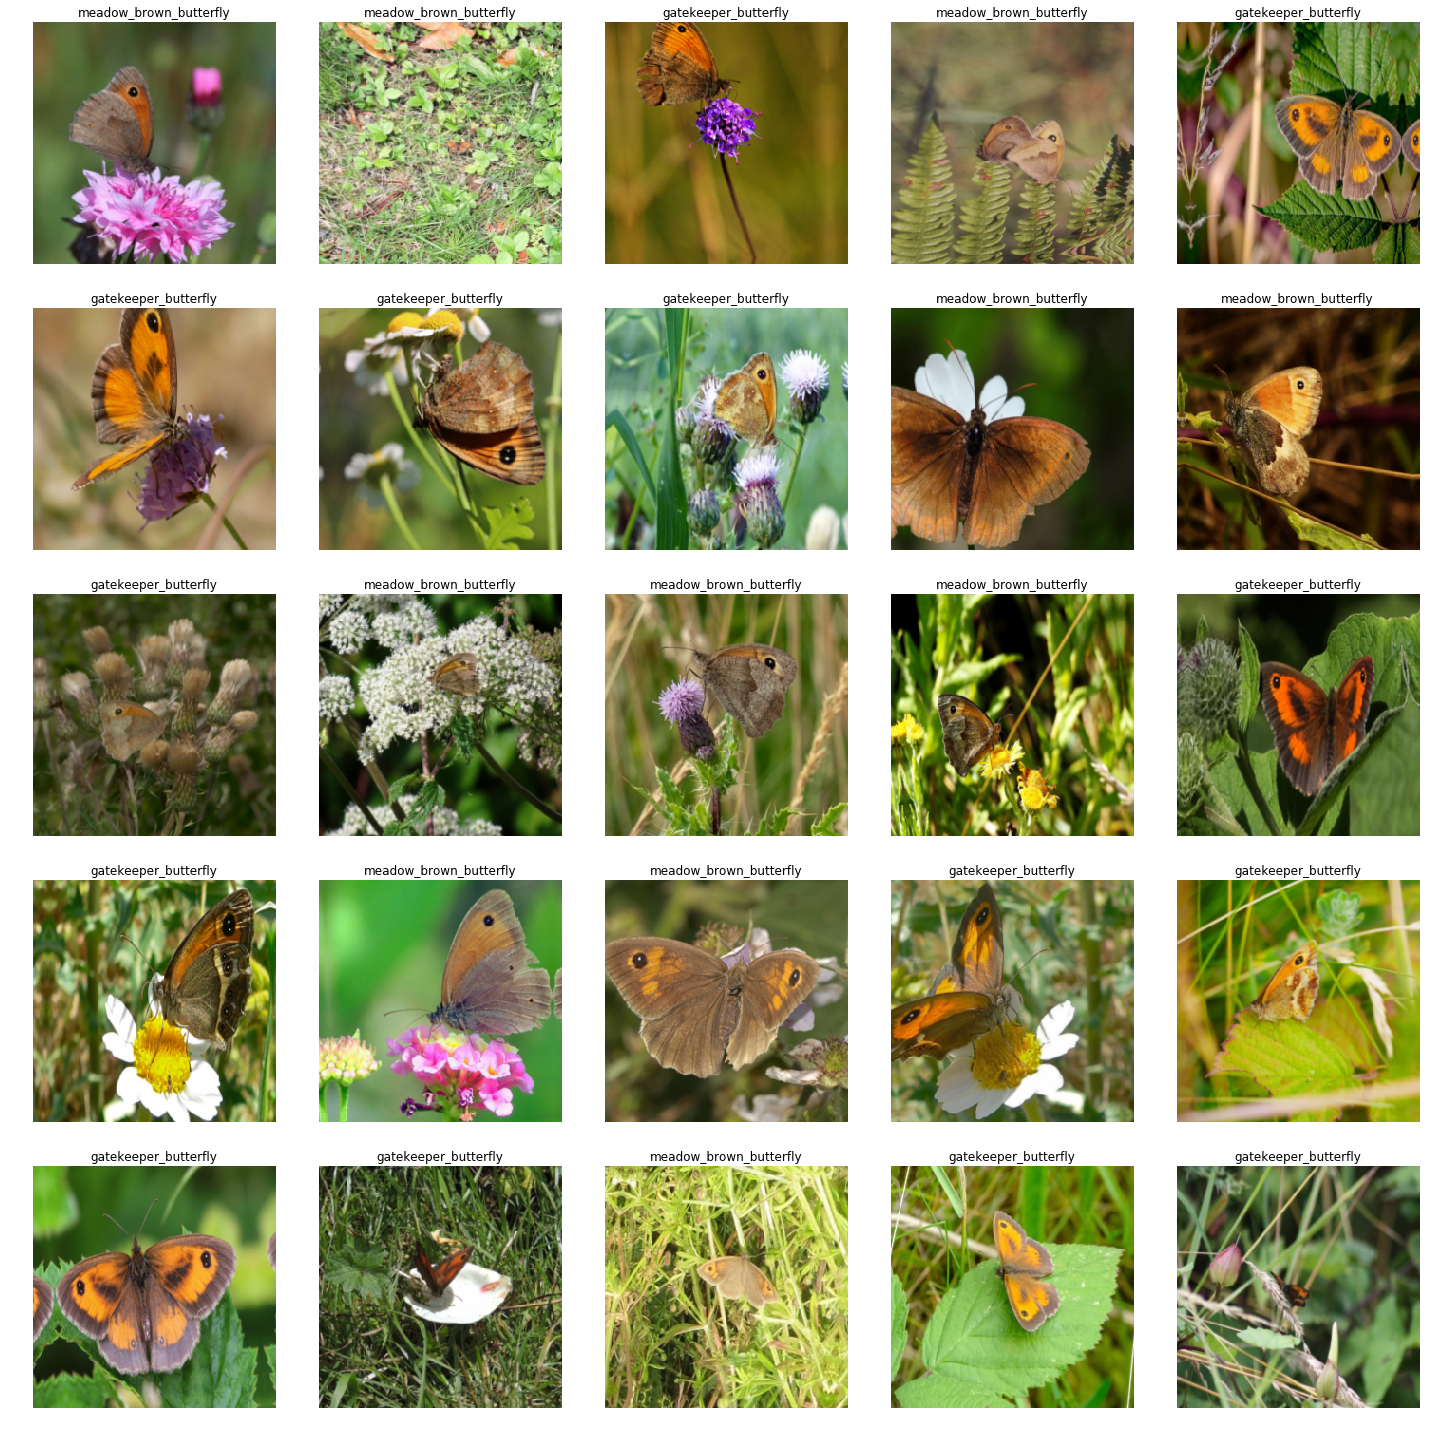

In [6]:
data.show_batch(ds_type=DatasetType.Train) # Preview a few images showing ground truth class

In [8]:
# Use Adam optimiser
opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)

print(f'lr: {lr}; size: {size}; alpha: {alpha}; mom: {mom}; eps: {eps}')

# Make a basic model and learner object based on Resnet 50
# Fast.ai sets a lot of sensible defaults, e.g. loss function based on knowledge 
# of the data inputs
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate])

# Potential performance optimisations depending on your system
if gpu is None:       learn.to_parallel()
elif num_distrib()>1: learn.to_distributed(gpu) # Requires `-m fastai.launch`

# Run 10 epochs of basic training at learning rate lr
# By default, most layers will be frozen other than the last few layers 
# which fast.ai will have added to give exactly two outputs (one per class).
learn.fit_one_cycle(10, lr)

# learn.fit(10, lr) would be the normal approach, but fit_one_cycle should 
# allow faster training. See https://sgugger.github.io/the-1cycle-policy.html

lr: 1e-05; size: 256; alpha: 0.9; mom: 0.9; eps: 1e-07


In [4]:
# Save model and training state so we can jump back to this point
learn.save('butterflies-full-1')

In [5]:
#learn.load('butterflies-full-1');

Happy so far that we're making progress on improved accuracy rate at the end of the 10th epoch. So next we'll unfreeze all layers on the resnet model. Further training can then change parameters throughout the model.

In [6]:
learn.unfreeze()

In [7]:
learn.fit_one_cycle(10, lr)

Better model found at epoch 0 with accuracy value: 0.6111111044883728.
Better model found at epoch 1 with accuracy value: 0.7685185074806213.
Better model found at epoch 2 with accuracy value: 0.7870370149612427.
Better model found at epoch 3 with accuracy value: 0.7962962985038757.
Better model found at epoch 6 with accuracy value: 0.8333333134651184.


In [8]:
learn.save('butterflies-full-2')

In [9]:
#learn.load('butterflies-full-2');

Learner(data=ImageDataBunch;

Train: LabelList (433 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
meadow_brown_butterfly,meadow_brown_butterfly,meadow_brown_butterfly,meadow_brown_butterfly,meadow_brown_butterfly
Path: butterfly_medium_images_full;

Valid: LabelList (108 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
meadow_brown_butterfly,meadow_brown_butterfly,gatekeeper_butterfly,gatekeeper_butterfly,gatekeeper_butterfly
Path: butterfly_medium_images_full;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
    

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


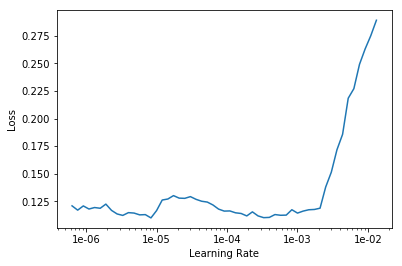

In [10]:
# Use fast.ai's learning rate analyser to see if we should adjust learning rate at this point.
# Ideally we would have found an initial learning rate using this method too!
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(3, max_lr=slice(2e-6,2e-4))

Better model found at epoch 0 with accuracy value: 0.8240740895271301.


In [12]:
learn.save('butterflies-full-3')

In [13]:
#learn.load('butterflies-full-3');

Learner(data=ImageDataBunch;

Train: LabelList (433 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
meadow_brown_butterfly,meadow_brown_butterfly,meadow_brown_butterfly,meadow_brown_butterfly,meadow_brown_butterfly
Path: butterfly_medium_images_full;

Valid: LabelList (108 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
meadow_brown_butterfly,meadow_brown_butterfly,gatekeeper_butterfly,gatekeeper_butterfly,gatekeeper_butterfly
Path: butterfly_medium_images_full;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
    

Fast.ai has a method to show us a selection of images and a comparison of their ground truth labels against the predictions made by the model. It's not bad but can we use our annotated bounding boxes to improve on this...? See next notebooks to find out!

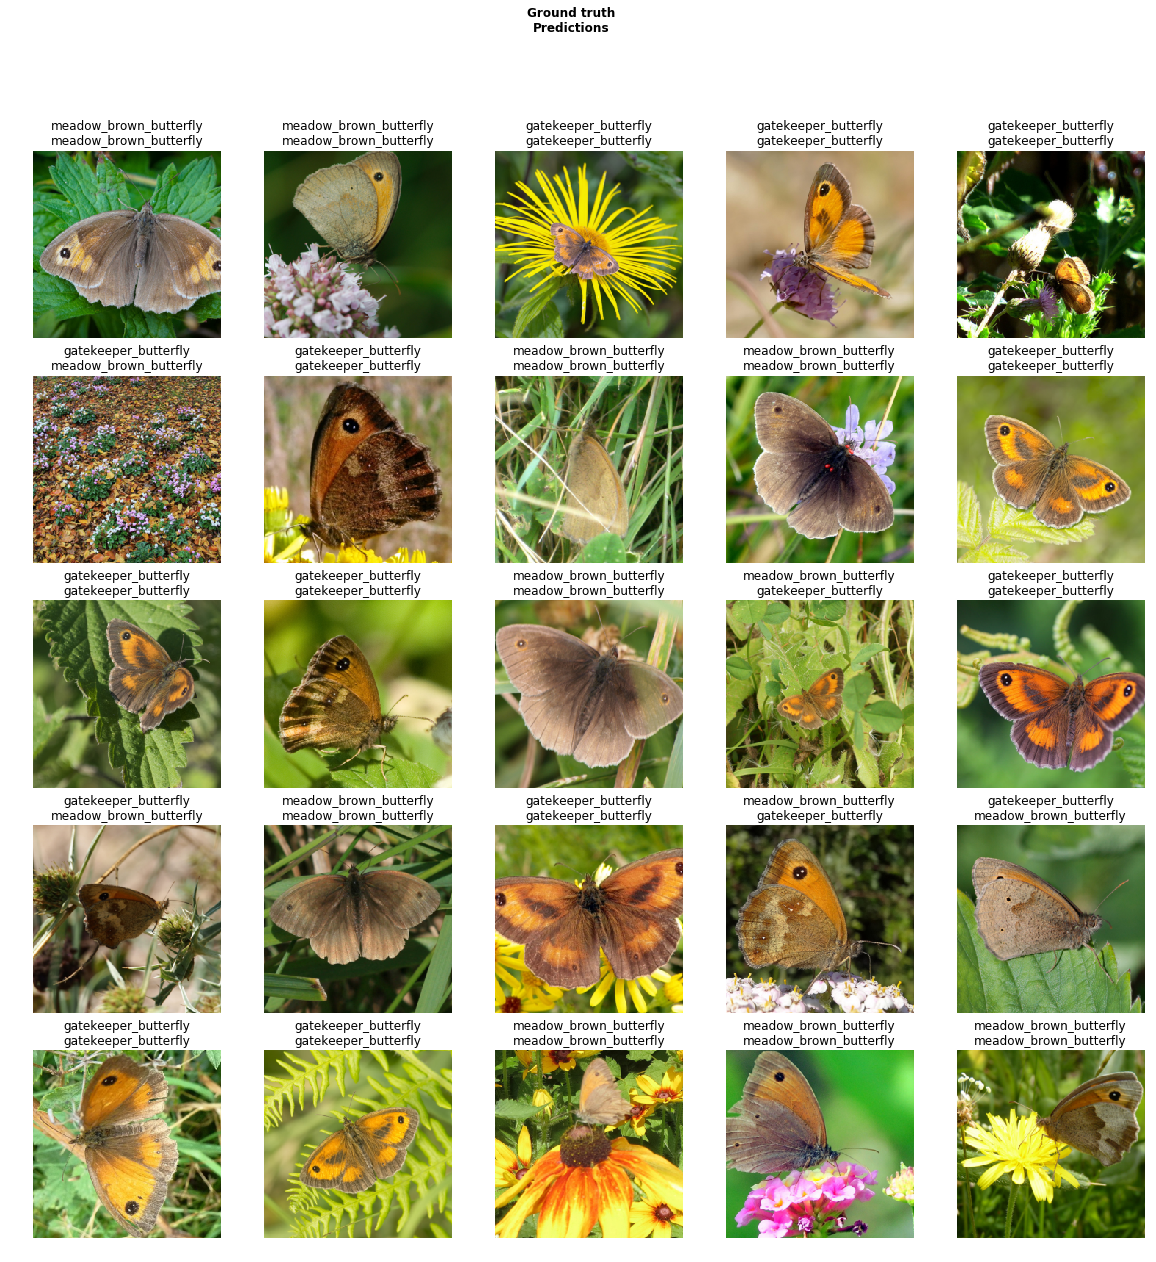

In [14]:
learn.show_results()